## demonstrate and explore Gaussian mechanism on release of means

** Load data and some utility functions

In [1]:
library("foreign")
par(ask=TRUE)

PUMSdata <- read.csv(file="https://raw.githubusercontent.com/privacytoolsproject/cs208/master/data/FultonPUMS5full.csv")   

data <- PUMSdata$educ    		# variable for means

data.x <- PUMSdata$educ			# x-variable for regression
data.y <- PUMSdata$income		# y-variable for regression

populationTrue <- mean(data)

## Bound/Censor/Clip/Clamp a variable to a range
clip <- function(x, lower, upper){
	x.clipped <- x
	x.clipped[x.clipped<lower] <- lower
	x.clipped[x.clipped>upper] <- upper
	return(x.clipped)	
}

## Sample with replacement from a vector
bootstrap <- function(x, y=NULL, n){
	index <- sample(x=1:length(x), size=n, replace=TRUE) 

	if(is.null(y)){
		return(x[index])
	}else{
		return(list(x=x[index], y=y[index]))
	}
}

Warning message:
“package ‘foreign’ was built under R version 3.4.4”

**show probability distributions, cumulatives and their inverses, for Gaussian distribution

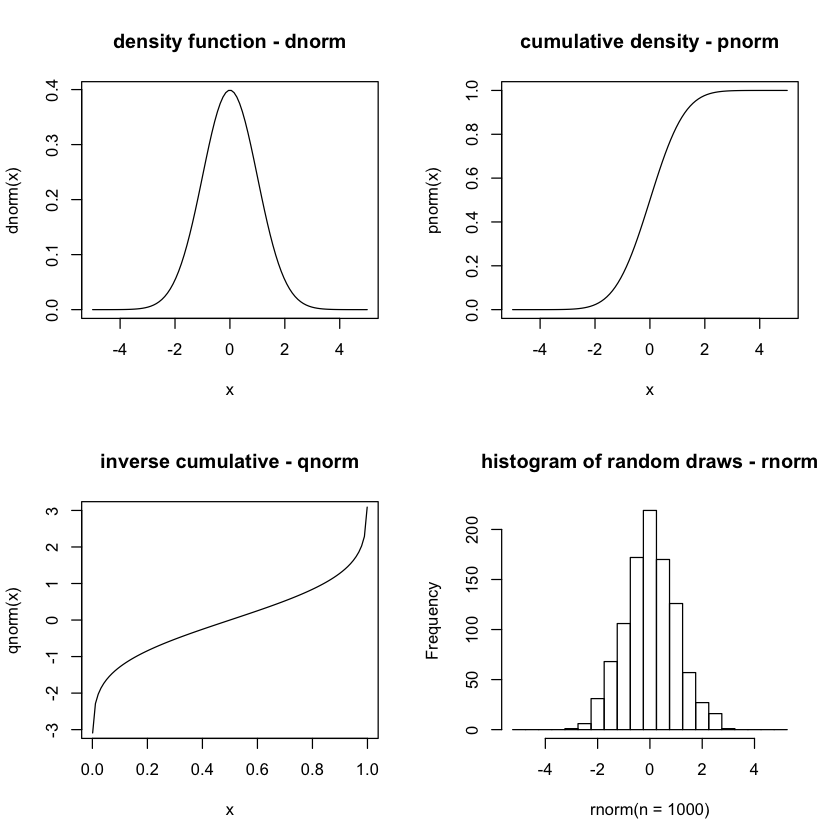

In [2]:
par(mfrow=c(2,2))
set.seed(123)

x<-seq(from=-5,to=5,length=100)

plot(x,dnorm(x),type="l",main="density function - dnorm")
plot(x,pnorm(x),type="l",main="cumulative density - pnorm")

x<-seq(from=.001,to=.999,length=100)
plot(x,qnorm(x),type="l",ylim=c(-3,3),main="inverse cumulative - qnorm")

hist(rnorm(n=1000),main="histogram of random draws - rnorm", breaks=seq(from=-5.25, to=5.25, by=0.5 ))


** Compare our mechanisms for the release of a mean

In [3]:
## Differentially private mean release using Laplace mechanism
laplaceMeanRelease <- function(x, lower, upper, epsilon){

	n <- length(x)
	sensitivity <- (upper - lower)/n
	scale <- sensitivity / epsilon

	x.clipped <- clip(x, lower, upper)
	sensitiveValue <- mean(x.clipped)
	DPrelease <- sensitiveValue + rlap(mu=0, b=scale, size=1)

	return(list(release=DPrelease, true=sensitiveValue))
}


## Differentially private mean release using Gaussian mechanism
gaussianMeanRelease <- function(x, lower, upper, epsilon, delta){

	n <- length(x)
	sensitivity <- (upper - lower)/n
	c <- sqrt(2*log(1.25/delta))
	scale <- c*sensitivity / epsilon

	x.clipped <- clip(x, lower, upper)
	sensitiveValue <- mean(x.clipped)
	DPrelease <- sensitiveValue + rnorm(mean=0, sd=scale, size=1)

	return(list(release=DPrelease, true=sensitiveValue))
}


** Demonstrate behaviour of ratios of Gaussians

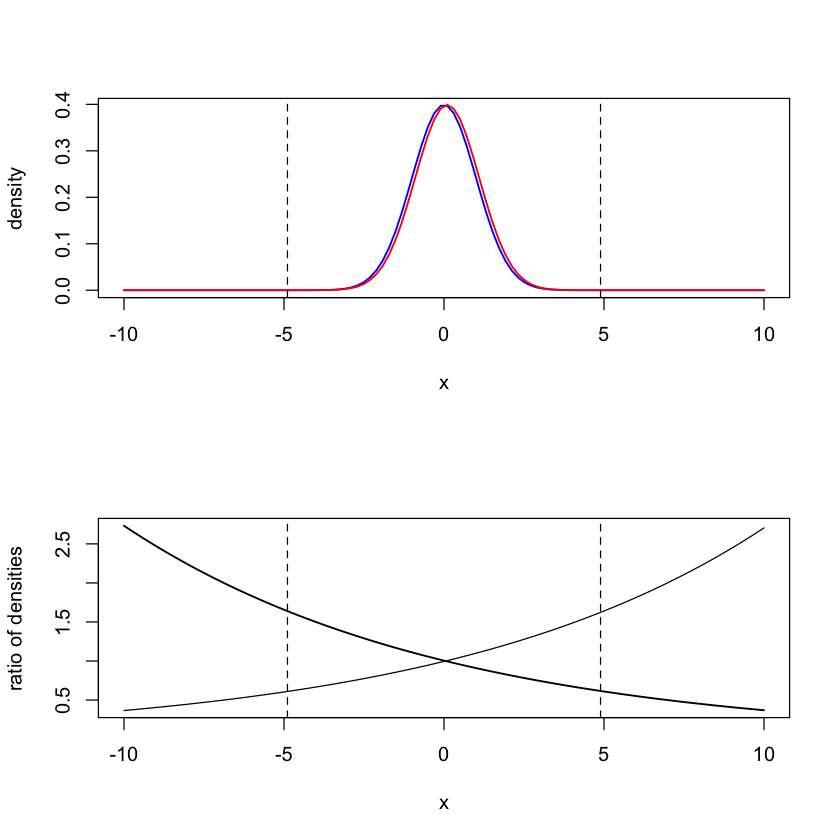

In [4]:
## Create two Gaussians and their ratio

delta <- 0.000001
x.seq <- seq(from=-10, to=10, length=100)

p1 <- dnorm(x.seq, mean=0, sd=1)
p2 <- dnorm(x.seq, mean=0.1, sd=1)

ratio1 <- p1/p2
ratio2 <- p2/p1


## Graph the ratios

par(mfcol=c(2,1))

plot(x=x.seq, y=p1, col="blue", type="l", lwd=1.5, xlab="x", ylab="density")
lines(x=x.seq, y=p2, col="red", lwd=1.5)

abline(v=qnorm(delta/2), lty=2)
abline(v=qnorm(1-delta/2), lty=2)


plot(x=x.seq, y=ratio1, type="l", lwd=1.5, xlab="x", ylab="ratio of densities")
lines(x=x.seq, y=ratio2)

abline(v=qnorm(delta/2), lty=2)
abline(v=qnorm(1-delta/2), lty=2)


**Show how epsilon varies over mean separation

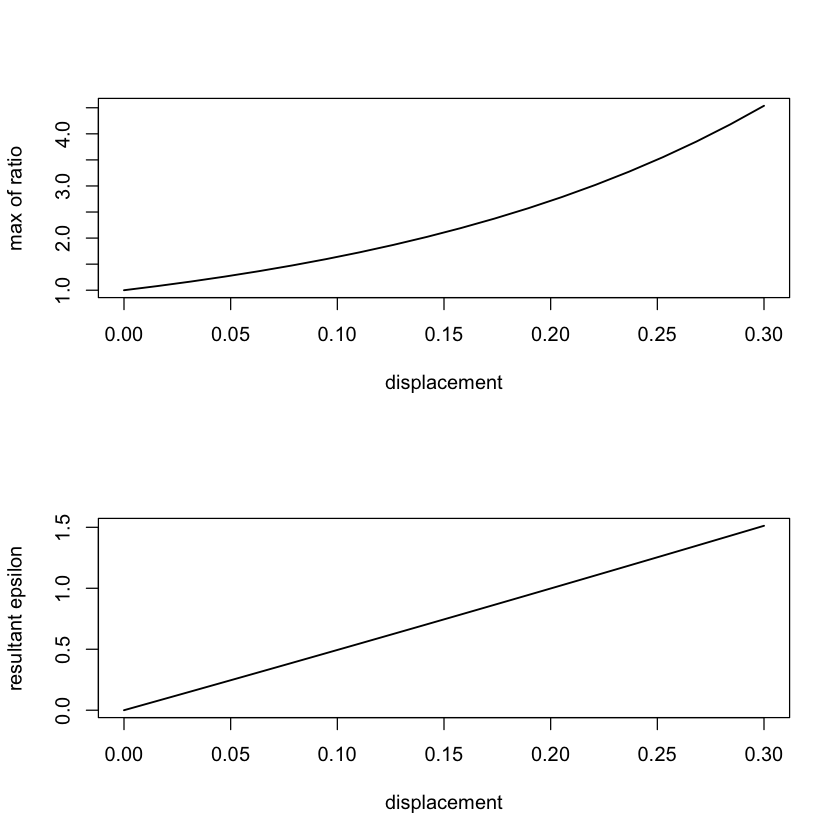

In [5]:
s<-seq(from=0, to=0.3, length=20) # Separation between means of two normals

max.ratio <- dnorm(qnorm(delta/2)) / dnorm(qnorm(delta/2) - s)

epsilon <- log(max.ratio)

par(mfcol=c(2,1))
plot(s, max.ratio, lwd=1.5, type="l", xlab="displacement", ylab="max of ratio")
plot(s, epsilon, lwd=1.5, type="l", xlab="displacement", ylab="resultant epsilon")


**Show relative contribution of epsilon and delta to noise of mechanism

In [6]:
# The Gaussian Mechanism's Standard Deviation of Noise
gmsd <- function(epsilon, delta, sensitivity=1){
	c <- sqrt(2*log(1.25/delta))
	sd <- c*sensitivity / epsilon
  	return(sd)
}

my.seq <- seq(from=log10(0.1), to=log10(1), length=20)     		# make evenly spaced in logarithmic space -- NOTE INCREASING VALUES
ep.seq <- round(10^my.seq * 100) /100							# round to two decimal places

my.seq <- seq(from=log10(1e-20), to=log10(1e-5), length=16)     # note scientific notation
del.seq <- 10^my.seq

zhistory <- matrix(NA, nrow=length(ep.seq), ncol=length(del.seq))
for(i in 1:length(ep.seq)){
	for(j in 1:length(del.seq)){
		zhistory[i,j] <- gmsd(epsilon=ep.seq[i], delta=del.seq[j], sensitivity=1)
	}
}

pdf 
  2

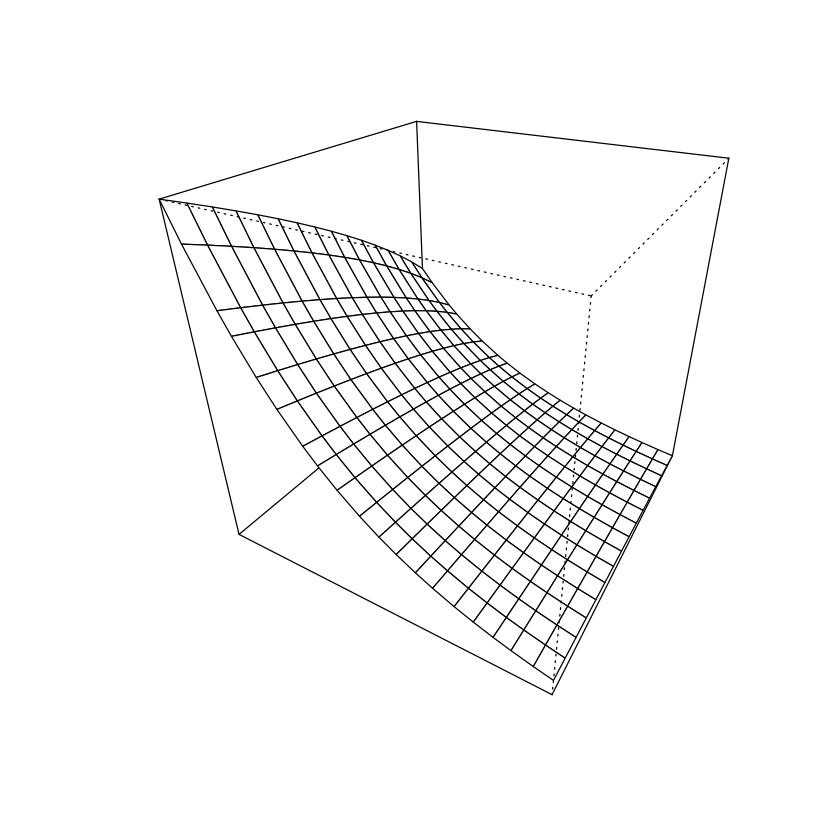

In [7]:

# Perspective plot of the utility surface
persp(x=log10(ep.seq), y=log10(del.seq), z=zhistory, axes=FALSE, theta=30, phi=30, xlab="epsilon", ylab="delta", zlab="sd noise")
dev.copy2pdf(file="./figs/gaussianUtility1.pdf")



pdf 
  2

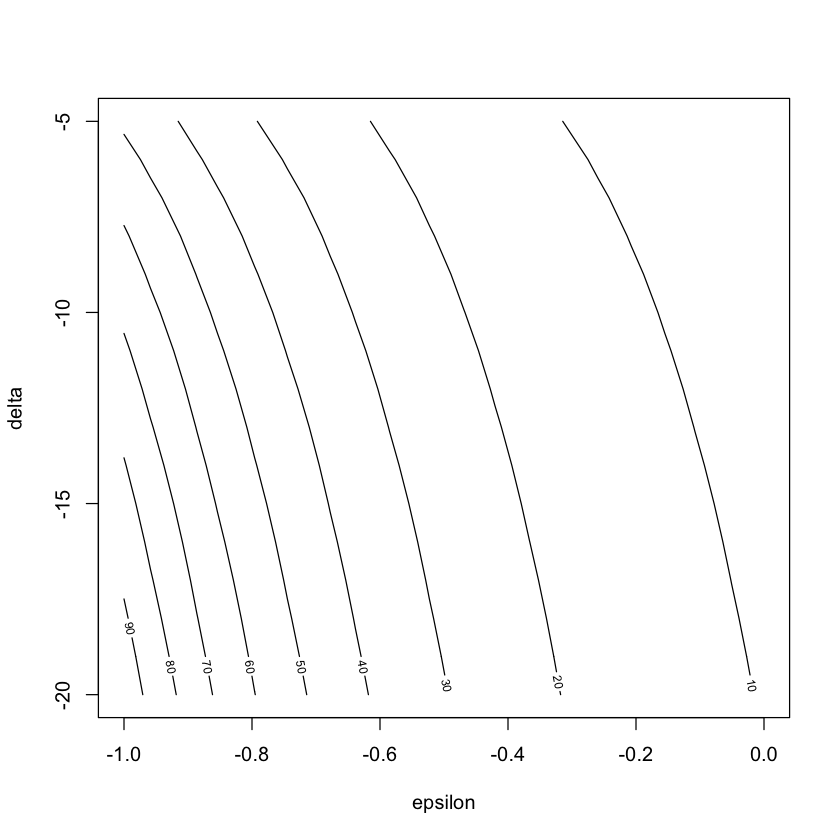

In [8]:

# Contour plot of the utility surface
contour(x=log10(ep.seq), y=log10(del.seq), z=zhistory, xlab="epsilon", ylab="delta")
dev.copy2pdf(file="./figs/gaussianUtility2.pdf")



pdf 
  2

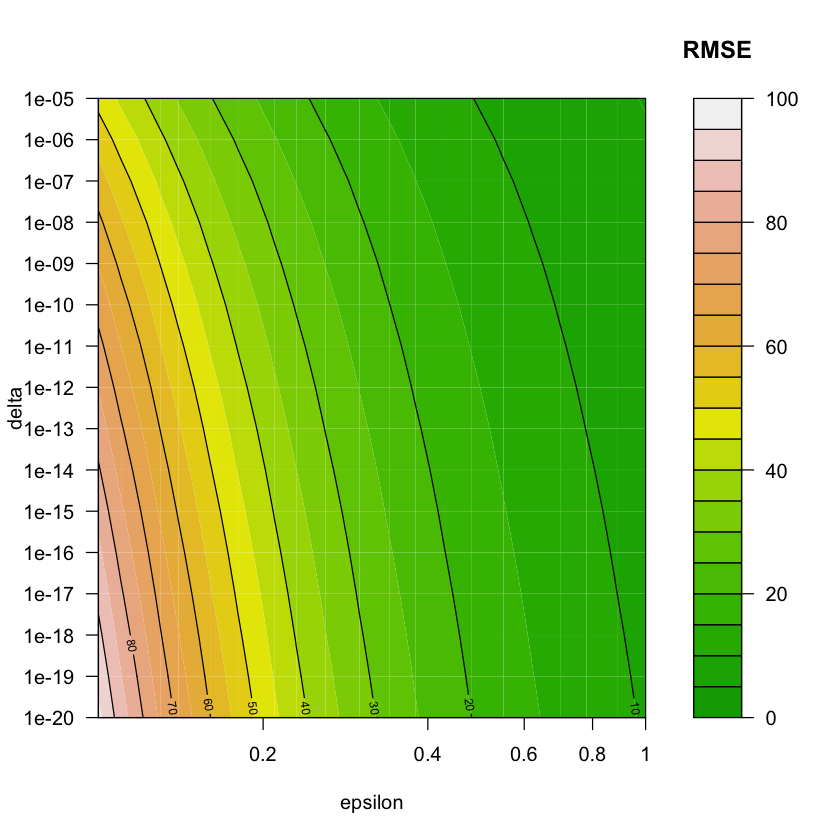

In [9]:

# "levels" plot of the utility surface
xtick <- pretty(ep.seq)
filled.contour(x=log10(ep.seq), y=log10(del.seq), z=zhistory, color = terrain.colors,  xlab="epsilon", ylab="delta", 
	plot.axes={contour(x=log10(ep.seq),y=log10(del.seq),z=zhistory,add=TRUE); 
	axis(1, at=log10(xtick), label=xtick); axis(2, at=log10(del.seq), label=del.seq)},
	key.title = title(main="RMSE"))
dev.copy2pdf(file="./figs/gaussianUtility3.pdf")

